In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("Weather-related disease prediction (1).csv")                                           # Cell 3: Make/normalize 3-class label (Heart Attack, Migraine, Other)

def _norm_label(x):
    return str(x).strip().lower()

def _map_to_3class(x):
    s = _norm_label(x)
    if s in {"heart attack", "heart-attack", "heart_attack", "heartattack"}:
        return "Heart Attack"
    if s in {"migraine", "migrane", "migraine headache", "migraine-"}:
        return "Migraine"
    return "Other"

if "prognosis_3class" not in df.columns:
    if "prognosis" not in df.columns:
        raise ValueError("Column 'prognosis' not found.")
    df["prognosis_3class"] = df["prognosis"].map(_map_to_3class)
else:
    df["prognosis_3class"] = df["prognosis_3class"].map(_map_to_3class)

df["prognosis_3class"].value_counts()

,count
prognosis_3class,
Other,3246
Heart Attack,1013
Migraine,941


In [3]:
print("Before cleaning:", df.shape)
print("Class distribution before cleaning:")
print(df["prognosis_3class"].value_counts())

Before cleaning: (5200, 52)
Class distribution before cleaning:
prognosis_3class
Other           3246
Heart Attack    1013
Migraine         941
Name: count, dtype: int64


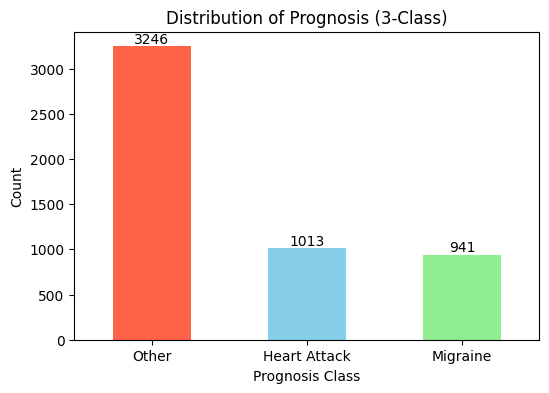

In [4]:
import matplotlib.pyplot as plt

counts = df["prognosis_3class"].value_counts()

plt.figure(figsize=(6,4))
ax = counts.plot(kind="bar", color=["tomato", "skyblue", "lightgreen"])
plt.title("Distribution of Prognosis (3-Class)")
plt.xlabel("Prognosis Class")
plt.ylabel("Count")
plt.xticks(rotation=0)

# Add values on top of each bar
for i, val in enumerate(counts):
    ax.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=10)

plt.show()




In [5]:
# Drop duplicate rows
dup_count = df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
print(f"Duplicates removed: {dup_count}")
print(df.shape)

Duplicates removed: 219
(4981, 52)


In [6]:
print("After duplicate removal:", df.shape)
print(df["prognosis_3class"].value_counts())

After duplicate removal: (4981, 52)
prognosis_3class
Other           3116
Heart Attack     968
Migraine         897
Name: count, dtype: int64


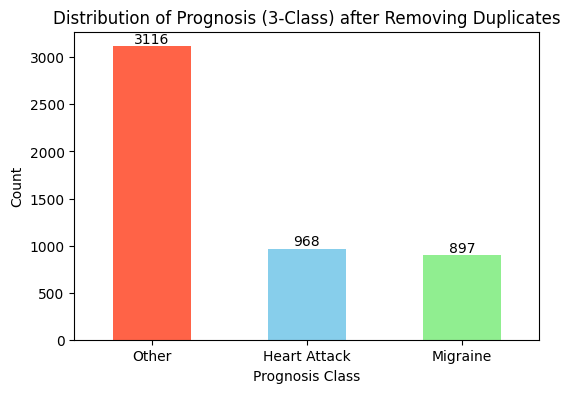

In [7]:
import matplotlib.pyplot as plt

counts = df["prognosis_3class"].value_counts()

plt.figure(figsize=(6,4))
ax = counts.plot(kind="bar", color=["tomato", "skyblue", "lightgreen"])
plt.title("Distribution of Prognosis (3-Class) after Removing Duplicates")
plt.xlabel("Prognosis Class")
plt.ylabel("Count")
plt.xticks(rotation=0)

for i, val in enumerate(counts):
    ax.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=10)

plt.show()


In [8]:
# Identify continuous & binary columns
continuous_cols = [c for c in ["Age", "Temperature (C)", "Humidity", "Wind Speed (km/h)"] if c in df.columns]

targets = {"prognosis", "prognosis_3class"}
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
binary_candidates = [c for c in num_cols if c not in set(continuous_cols) | targets]

print("Continuous:", continuous_cols)
print("Binary candidates (will enforce 0/1):", binary_candidates[:10], " ... total:", len(binary_candidates))

Continuous: ['Age', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
Binary candidates (will enforce 0/1): ['Gender', 'nausea', 'joint_pain', 'abdominal_pain', 'high_fever', 'chills', 'fatigue', 'runny_nose', 'pain_behind_the_eyes', 'dizziness']  ... total: 46


In [9]:
# Clip impossible/implausible values to safe bounds
clip_bounds = {
    "Age": (0, 120),
    "Temperature (C)": (-30, 55),
    "Humidity": (0, 100),
    "Wind Speed (km/h)": (0, 200),
}

for col in continuous_cols:
    lo, hi = clip_bounds[col]
    outliers = ((df[col] < lo) | (df[col] > hi)).sum()
    df[col] = df[col].clip(lower=lo, upper=hi)
    print(f"{col}: clipped {outliers} values to [{lo}, {hi}]")

df[continuous_cols].describe().T

Age: clipped 0 values to [0, 120]
Temperature (C): clipped 0 values to [-30, 55]
Humidity: clipped 0 values to [0, 100]
Wind Speed (km/h): clipped 0 values to [0, 200]


,count,mean,std,min,25%,50%,75%,max
Age,4981.0,51.290905,26.624880,1.000000,29.000000,53.000000,74.000,100.000000
Temperature (C),4981.0,19.962910,11.439338,-15.125000,12.212269,20.081713,28.540,40.996000
Humidity,4981.0,0.745075,0.143060,0.370833,0.624167,0.750000,0.860,1.000000
Wind Speed (km/h),4981.0,10.706016,5.672566,0.008000,6.415179,10.185933,15.062,31.303096


In [10]:
clip_bounds = {
    "Age": (0, 120),
    "Temperature (C)": (-30, 55),
    "Humidity": (0, 100),
    "Wind Speed (km/h)": (0, 200),
}


mask = np.ones(len(df), dtype=bool)
for col in continuous_cols:
    lo, hi = clip_bounds[col]
    bad = ~df[col].between(lo, hi)
    print(f"{col}: removing {bad.sum()} outliers outside [{lo}, {hi}]")
    mask &= df[col].between(lo, hi)


df = df[mask].reset_index(drop=True)

print("After outlier removal:", df.shape)
print(df[continuous_cols].describe().T)


Age: removing 0 outliers outside [0, 120]
Temperature (C): removing 0 outliers outside [-30, 55]
Humidity: removing 0 outliers outside [0, 100]
Wind Speed (km/h): removing 0 outliers outside [0, 200]
After outlier removal: (4981, 52)
                    count       mean        std        min        25%  \
Age                4981.0  51.290905  26.624880   1.000000  29.000000   
Temperature (C)    4981.0  19.962910  11.439338 -15.125000  12.212269   
Humidity           4981.0   0.745075   0.143060   0.370833   0.624167   
Wind Speed (km/h)  4981.0  10.706016   5.672566   0.008000   6.415179   

                         50%     75%         max  
Age                53.000000  74.000  100.000000  
Temperature (C)    20.081713  28.540   40.996000  
Humidity            0.750000   0.860    1.000000  
Wind Speed (km/h)  10.185933  15.062   31.303096  


In [11]:
# After outlier removal
print("After outlier removal:", df.shape)
print(df["prognosis_3class"].value_counts())

After outlier removal: (4981, 52)
prognosis_3class
Other           3116
Heart Attack     968
Migraine         897
Name: count, dtype: int64


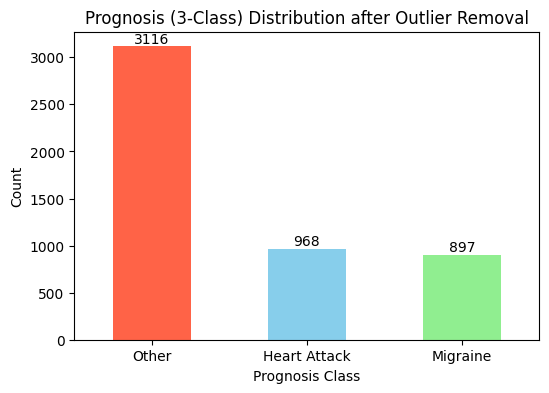

In [12]:
import matplotlib.pyplot as plt

# Class distribution after outlier removal
counts = df["prognosis_3class"].value_counts()

plt.figure(figsize=(6,4))
counts.plot(kind="bar", color=["tomato", "skyblue", "lightgreen"])
plt.title("Prognosis (3-Class) Distribution after Outlier Removal")
plt.xlabel("Prognosis Class")
plt.ylabel("Count")
plt.xticks(rotation=0)


for i, val in enumerate(counts):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)

plt.show()


In [13]:
# Save the outlier-removed dataset
outlier_removed_csv = "weather_disease_outliers_removed.csv"
df.to_csv(outlier_removed_csv, index=False)
print(f"Saved outlier-removed dataset: {outlier_removed_csv}")




Saved outlier-removed dataset: weather_disease_outliers_removed.csv


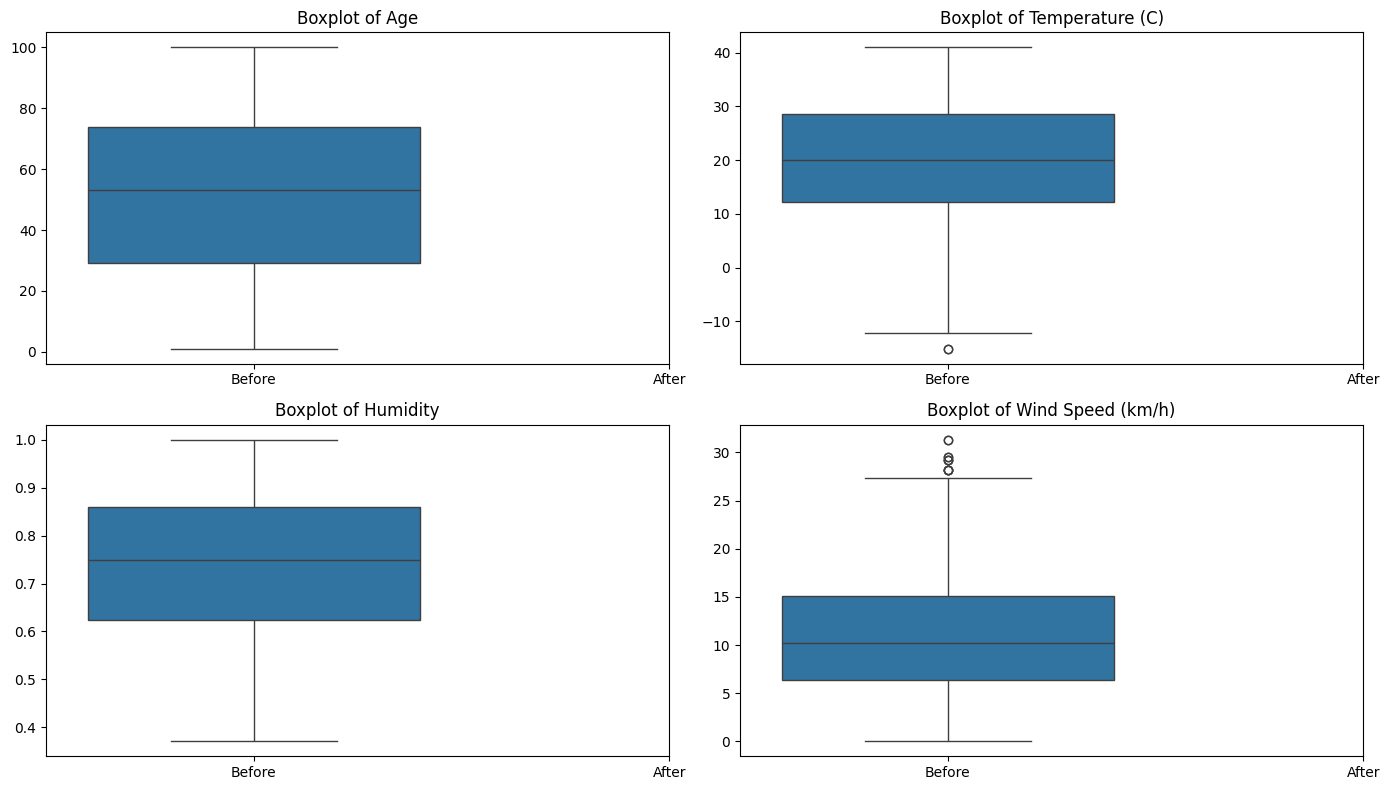

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = pd.read_csv("Weather-related disease prediction (1).csv")
df_clean = pd.read_csv("weather_disease_outliers_removed.csv")

continuous_cols = ["Age", "Temperature (C)", "Humidity", "Wind Speed (km/h)"]


plt.figure(figsize=(14,8))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=[df_raw[col], df_clean[col]], orient="v")
    plt.xticks([0,1], ["Before", "After"])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()



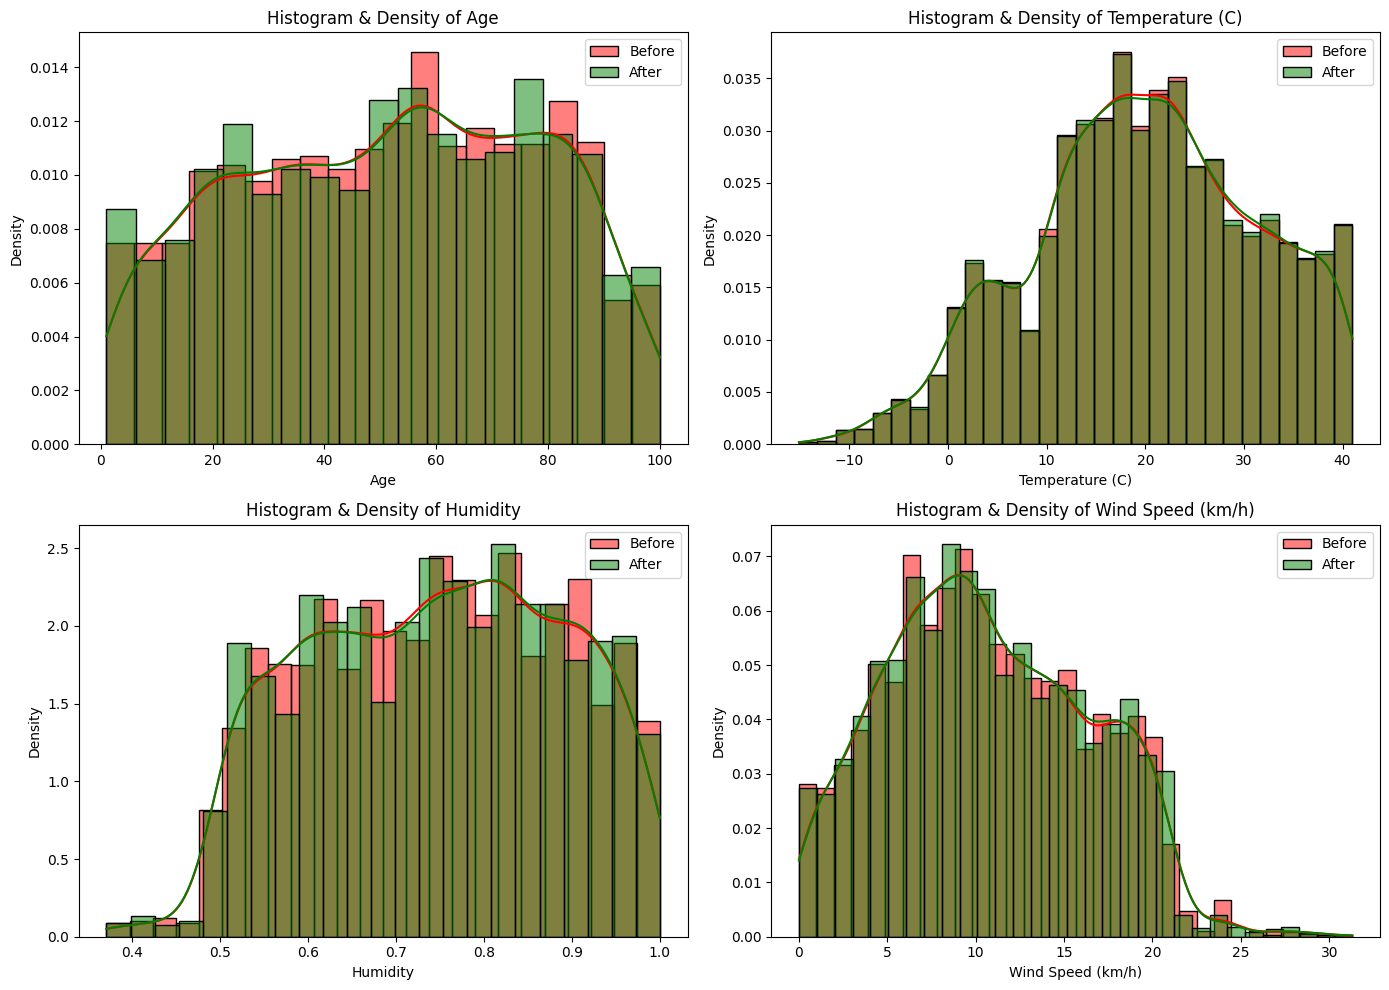

In [15]:

plt.figure(figsize=(14,10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_raw[col], color="red", kde=True, label="Before", stat="density", alpha=0.5)
    sns.histplot(df_clean[col], color="green", kde=True, label="After", stat="density", alpha=0.5)
    plt.title(f"Histogram & Density of {col}")
    plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Summary statistics before vs. after
summary_raw = df_raw[continuous_cols].describe().T
summary_clean = df_clean[continuous_cols].describe().T

print("Summary Statistics (Before Cleaning):")
print(summary_raw)
print("\nSummary Statistics (After Outlier Removal):")
print(summary_clean)

# Combine side by side for easier comparison
summary_compare = summary_raw.join(summary_clean, lsuffix="_before", rsuffix="_after")
print("\nComparison of Before vs After Cleaning:")
print(summary_compare)


Summary Statistics (Before Cleaning):
                    count       mean        std        min        25%  \
Age                5200.0  51.383269  26.625863   1.000000  30.000000   
Temperature (C)    5200.0  19.943117  11.414905 -15.125000  12.184500   
Humidity           5200.0   0.744873   0.142860   0.370833   0.624479   
Wind Speed (km/h)  5200.0  10.708818   5.686331   0.008000   6.414508   

                       50%       75%         max  
Age                53.0000  74.00000  100.000000  
Temperature (C)    20.0175  28.46525   40.996000  
Humidity            0.7500   0.86000    1.000000  
Wind Speed (km/h)  10.1525  15.06155   31.303096  

Summary Statistics (After Outlier Removal):
                    count       mean        std        min        25%  \
Age                4981.0  51.290905  26.624880   1.000000  29.000000   
Temperature (C)    4981.0  19.962910  11.439338 -15.125000  12.212269   
Humidity           4981.0   0.745075   0.143060   0.370833   0.624167   
Wind